In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import logging

logging.getLogger('jieba').setLevel(logging.WARN)
logging.getLogger('fgclassifier').setLevel(logging.INFO)
logging.getLogger('fgclassifier.features').setLevel(logging.INFO)

In [2]:
import os

os.chdir('..')

In [3]:
from fgclassifier.utils import read_data, get_dataset

X_train, y_train = read_data(get_dataset('train_en'), flavor=None)
X_train.shape

2018-12-04 16:04:08,953 [INFO] Reading /opt/storage/english_train.csv..


(8000,)

Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-3:
  File "/Users/jesse/anaconda3/envs/idp/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jesse/anaconda3/envs/idp/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jesse/anaconda3/envs/idp/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/jesse/anaconda3/envs/idp/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jesse/anaconda3/envs/idp/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jesse/anaconda3/envs/idp/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/Users/jes

Exam the usage of np.linspace/logspace

In [4]:
np.linspace(100, 1000, 10)

array([ 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,
       1000.])

In [5]:
np.logspace(-4, 4, 9)

array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])

In [6]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

Build the features

In [7]:
from sklearn.pipeline import Pipeline
from fgclassifier.features import Count, Tfidf

pipeline = Pipeline([
    ('vect', Count(min_df=0.02, max_df=0.99, ngram_range=(1, 6))),
    ('tfidf', Tfidf()),
], memory='data/pipeline_cache')

Xt = pipeline.fit_transform(X_train)

2018-12-04 16:04:44,306 [INFO] 'pattern' package not found; tag filters are not available for English
2018-12-04 16:05:07,442 [INFO] Fit & Transform TF-IDF...


In [11]:
print('Original data dimension: ',
      len(pipeline.named_steps.tfidf.idf_))

Original data dimension:  2612


## Optimize classifier 

We use TruncatedSVD for dimension reduction, then pass the reduced dataset
to LDA. This is more efficient as this way we can handle sparse matrix whereas
LDA requires dense matrix input.

In [22]:
from IPython.display import clear_output
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD

from fgclassifier.baseline import Baseline, MultiOutputClassifier
from fgclassifier.classifiers import LinearDiscriminantAnalysis as LDA


max_dim = min(len(pipeline.named_steps.tfidf.idf_) - 1, 1500)

clf = Pipeline([
    ('svd', TruncatedSVD(n_components=100)),
    ('clf', MultiOutputClassifier(LDA()))
])

parameters = {
    'svd__n_components': np.linspace(100, max_dim, 15, dtype=int)
}

with joblib.parallel_backend('threading', n_jobs=3):
    searcher = GridSearchCV(
        clf, parameters, cv=5,
        verbose=True,
        return_train_score=True
    )
    display(searcher)
    searcher.fit(Xt, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('svd', TruncatedSVD(algorithm='randomized', n_components=100, n_iter=5,
       random_state=None, tol=0.0)), ('clf', MultiOutputClassifier(estimator=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001),
           n_jobs=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'svd__n_components': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 

2018-12-04 17:42:59,077 [INFO]  F1 Score: 0.6420345263920353
/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 17:43:25,160 [INFO]  F1 Score: 0.43954915138648853
2018-12-04 17:43:27,667 [INFO]  F1 Score: 0.6495011579131356
2018-12-04 17:43:37,885 [INFO]  F1 Score: 0.452304857200582
2018-12-04 17:43:39,396 [INFO]  F1 Score: 0.6756259494577732
/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 17:43:58,352 [INFO]  F1 Score: 0.4553207578635486
2018-12-04 17:44:01,609 [INFO]  F1 Score: 0.6765356442998434
/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/m

/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 18:00:49,215 [INFO]  F1 Score: 0.47376209886069603
2018-12-04 18:00:50,364 [INFO]  F1 Score: 0.7832964421762093
2018-12-04 18:01:51,331 [INFO]  F1 Score: 0.461889662061592
2018-12-04 18:01:52,547 [INFO]  F1 Score: 0.7829870675416802
2018-12-04 18:02:39,457 [INFO]  F1 Score: 0.46111934345262623
2018-12-04 18:02:40,808 [INFO]  F1 Score: 0.7999550385723762
/Users/jesse/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2018-12-04 18:03:25,100 [INFO]  F1 Score: 0.46834939324365454
2018-12-04 18:03:30,598 [INFO]  F1 Score: 0.7990588126979169
/Users

In [24]:
searcher.best_estimator_

Pipeline(memory=None,
     steps=[('svd', TruncatedSVD(algorithm='randomized', n_components=1000, n_iter=5,
       random_state=None, tol=0.0)), ('clf', MultiOutputClassifier(estimator=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001),
           n_jobs=None))])

In [34]:
pd.DataFrame(searcher.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svd__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,6.452438,0.681236,0.111136,0.031978,100,{'svd__n_components': 100},0.375237,0.377288,0.372036,0.380044,...,0.375944,0.002649,15,0.414966,0.414634,0.421559,0.419270,0.416842,0.417454,0.002633
1,13.062101,1.461925,0.384753,0.069511,200,{'svd__n_components': 200},0.406048,0.408557,0.401983,0.419465,...,0.408504,0.005880,14,0.498093,0.506501,0.504721,0.500600,0.502594,0.502502,0.002966
2,21.518140,0.613587,0.440602,0.053048,300,{'svd__n_components': 300},0.422217,0.422986,0.417377,0.441788,...,0.425367,0.008456,13,0.560923,0.561012,0.562943,0.560874,0.560538,0.561258,0.000857
3,30.468148,0.406348,0.601676,0.211813,400,{'svd__n_components': 400},0.436474,0.439394,0.435371,0.444386,...,0.439004,0.003126,12,0.606781,0.607615,0.604466,0.604554,0.611035,0.606890,0.002410
4,39.235896,1.747058,0.779476,0.281692,500,{'svd__n_components': 500},0.446394,0.449529,0.445211,0.459880,...,0.448113,0.006711,11,0.645953,0.643185,0.641977,0.642035,0.649501,0.644530,0.002874
5,55.670888,1.751257,1.099481,0.258909,600,{'svd__n_components': 600},0.452305,0.455321,0.451866,0.466667,...,0.454096,0.007256,10,0.675626,0.676536,0.674314,0.672117,0.676948,0.675108,0.001747
6,69.591615,2.768742,1.766032,0.653924,700,{'svd__n_components': 700},0.454222,0.461893,0.459831,0.461951,...,0.457508,0.004838,9,0.704775,0.701474,0.700330,0.699919,0.706414,0.702582,0.002564
7,80.152265,3.198933,1.808167,0.947183,800,{'svd__n_components': 800},0.457675,0.462736,0.457783,0.472002,...,0.461208,0.005862,8,0.726990,0.724785,0.726001,0.724506,0.727220,0.725900,0.001107
8,95.521593,12.308287,3.315945,1.230151,900,{'svd__n_components': 900},0.462536,0.465085,0.462069,0.473262,...,0.464623,0.004596,7,0.749239,0.745446,0.746784,0.745848,0.746916,0.746847,0.001318
9,153.582857,12.045664,3.232583,2.601338,1000,{'svd__n_components': 1000},0.462514,0.473699,0.465558,0.478355,...,0.468376,0.006544,1,0.766676,0.764909,0.764659,0.765447,0.766888,0.765716,0.000909


In [41]:
import seaborn as sns

def extract_results(searcher, params):
    """Process the results for display"""
    colnames = [f'param_{x}' for x in params]
    results =  pd.melt(
        pd.DataFrame(searcher.cv_results_),
        id_vars=colnames,
        value_vars=[
            'mean_test_score',
            'mean_train_score',
        ],
        value_name='score'
    )
    results.columns = params + ['variable', 'score']
    results['train_or_test'] = np.where(results['variable'].str.contains('test'),
                                        'test', 'train')
    results = results.drop(['variable'], axis=1)
    return results

results = extract_results(searcher, ['svd__n_components'])
results.head()

,svd__n_components,score,train_or_test
0,100,0.375944,test
1,200,0.408504,test
2,300,0.425367,test
3,400,0.439004,test
4,500,0.448113,test


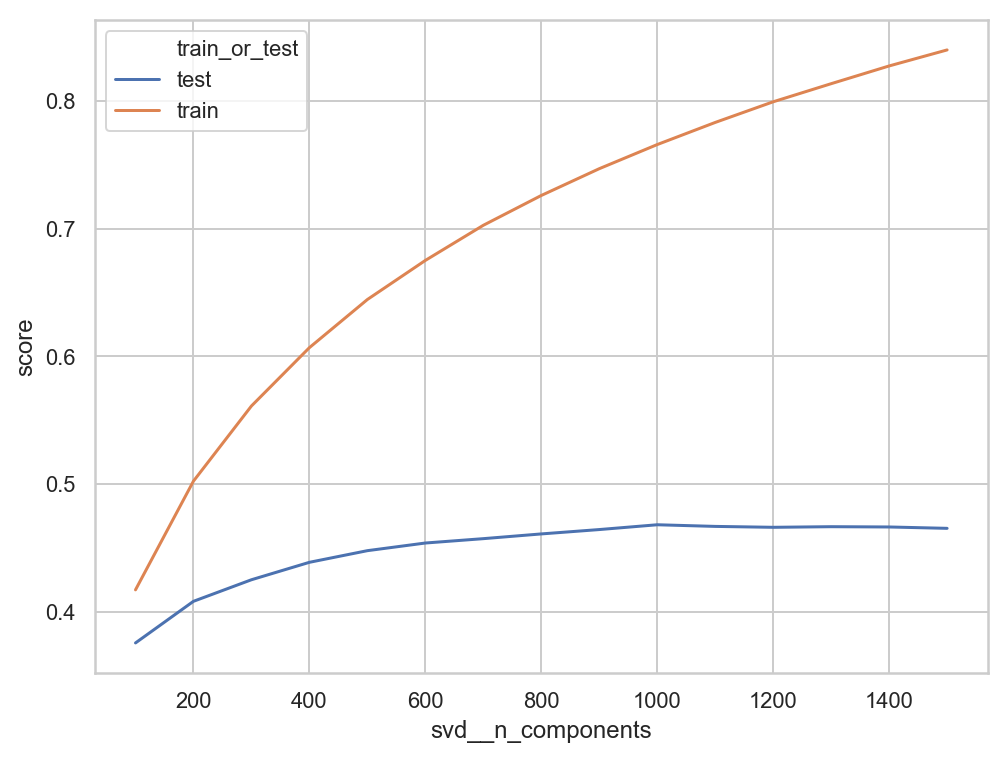

In [58]:
import seaborn as sns

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    x='svd__n_components',
    y='score',
    hue='train_or_test',
    data=results,
    ax=ax
)

Looks like the LDA paramater does not matter for LDA.